# Make Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
sns.set_context('talk')

## About the Dataset

The filenames with `tempR12-Run6-stable.csv` are output of the script `eval-bad-rtds.py`. Basically, the script find the bad sensors in a raft with a clustering algorithm and outputs the mean over the good sensor and the temperature offsets.

This time-series is compressed within a time window of:

```
end_date = '2023-06-26 04:00:00'
start_date = '2023-06-24 18:30:43'
```

And the data was resampled to take the average over a 5min.

In [3]:
# df.index

In [4]:
e2vRaftList = ["R11", "R12", "R13", "R14", "R21", "R22", 
               "R23", "R24", "R30", "R31", "R32", "R33", "R34"]

datas = []
for raft in e2vRaftList:
    path = '../data/ccsTemp/'
    fnameRaft = path+'temp%s-Run6-stable.csv'
    df = pd.read_csv(fnameRaft%raft)
    df['datetime'] = pd.to_datetime(df['datetime'])
    datas.append(df.set_index('datetime'))

In [9]:
df.index

DatetimeIndex(['2023-06-24 18:30:00-07:00', '2023-06-24 18:35:00-07:00',
               '2023-06-24 18:40:00-07:00', '2023-06-24 18:45:00-07:00',
               '2023-06-24 18:50:00-07:00', '2023-06-24 18:55:00-07:00',
               '2023-06-24 19:00:00-07:00', '2023-06-24 19:05:00-07:00',
               '2023-06-24 19:10:00-07:00', '2023-06-24 19:15:00-07:00',
               ...
               '2023-06-26 02:45:00-07:00', '2023-06-26 02:50:00-07:00',
               '2023-06-26 02:55:00-07:00', '2023-06-26 03:00:00-07:00',
               '2023-06-26 03:05:00-07:00', '2023-06-26 03:10:00-07:00',
               '2023-06-26 03:15:00-07:00', '2023-06-26 03:20:00-07:00',
               '2023-06-26 03:25:00-07:00', '2023-06-26 03:30:00-07:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-420)]', name='datetime', length=397, freq='5T')

In [10]:
df = pd.concat(datas, axis=1)
# df = df.set_index('datetime')
df = df.interpolate()

In [11]:
end_date = '2023-06-25 18:00:00'
start_date = '2023-06-24 18:30:43'

# end_date = '2023-06-24 18:00:00'
# start_date = '2023-06-24 13:30:43'

mask = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[mask]

In [12]:
datas2 = []
fnameBadRaft = path+'bad-sensors-%s.csv'
for raft in e2vRaftList:
    fname = fnameBadRaft%raft
    _df = pd.read_csv(fname)
    _df['sensor-only'] = _df['Sensor'].apply(lambda x: x.split('-')[1])
    datas2.append(_df)

df2 = pd.concat(datas2).reset_index()

In [45]:
columns = [col.split('_')[1] for col in df.columns if 'Temp_R' in col[:10]]
labels = np.zeros((len(columns),),dtype=int)
bad_sensors = list(df2['Sensor'][df2.Offset>3.])
for i, col in enumerate(columns):
    if col in bad_sensors: labels[i] = 1

In [14]:
df2[['Sensor','Tmean','Tstd','Offset']][df2.Offset>3.].sort_values('Offset')

,Sensor,Tmean,Tstd,Offset
15,R24-S22,-103.039241,0.914328,3.060444
3,R13-S21,-103.510844,0.837468,3.552523
19,R31-S22,-102.969325,0.969114,4.549075
24,R33-S11,-101.229875,0.700684,4.818842
26,R34-S01,-102.658215,1.135164,6.218685
1,R12-S22,-102.883447,0.922887,7.813364
9,R21-S21,-102.964423,0.694578,11.714886
8,R21-S00,-102.964423,0.694578,15.424029


## Study Bad Sensor Raft

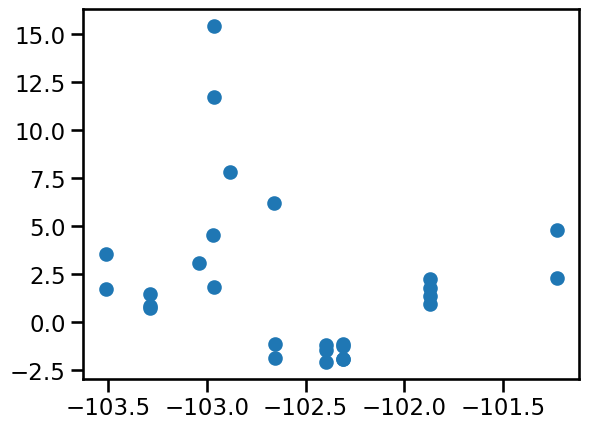

In [15]:
plt.scatter(df2.Tmean, df2.Offset)

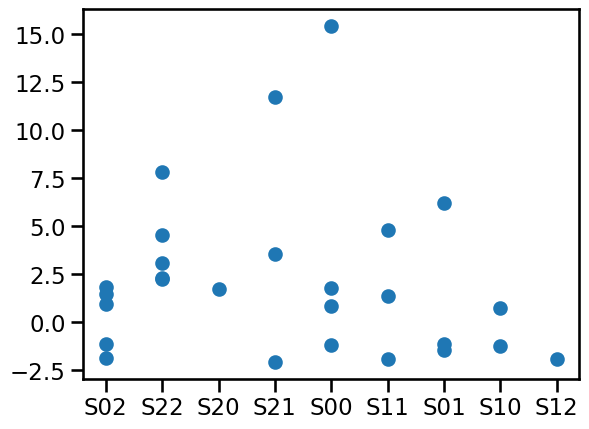

In [16]:
plt.scatter(df2['sensor-only'], df2.Offset)

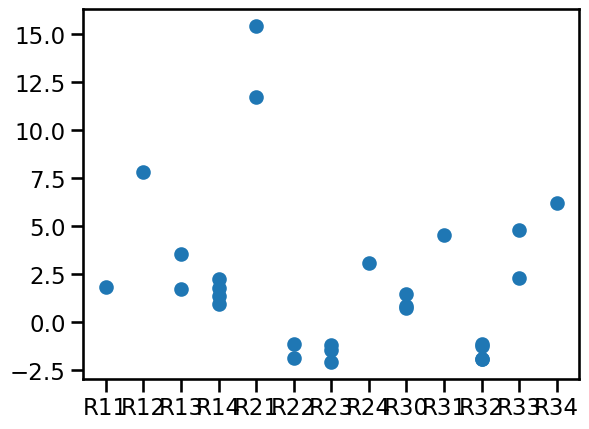

In [17]:
plt.scatter(df2.Raft, df2.Offset)

Text(0, 0.5, 'Raft Mean RTD Temp')

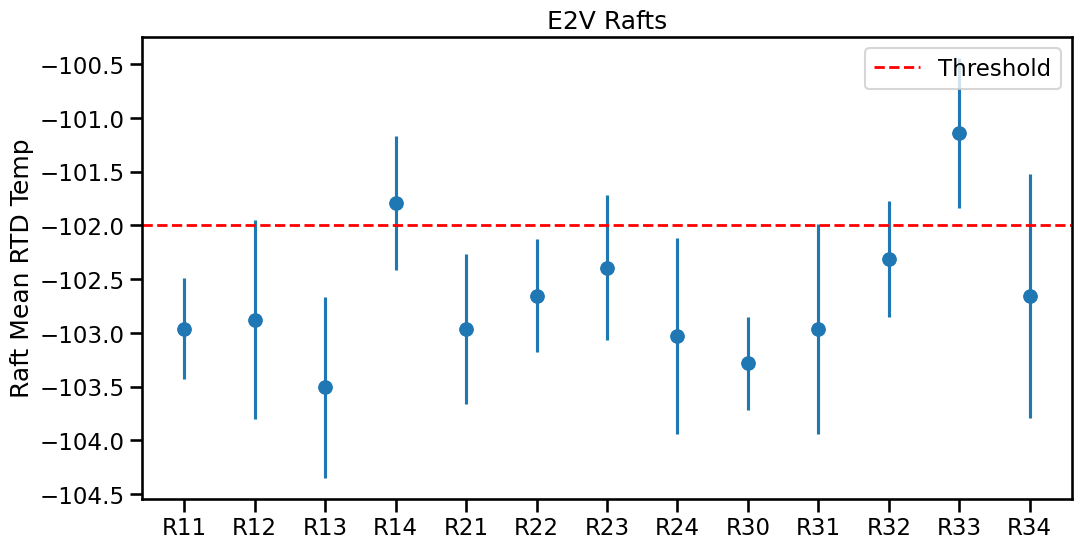

In [18]:
raft_means = [df['T_%s_mean'%raft].mean() for raft in e2vRaftList]
raft_std = [df['T_%s_std'%raft].mean() for raft in e2vRaftList]

plt.figure(figsize=(12,6))
plt.scatter(e2vRaftList, raft_means)
plt.errorbar(e2vRaftList, raft_means, yerr=raft_std, fmt='o')
plt.axhline(-102.,color='r',ls='--',lw=2,label='Threshold')
plt.legend()
plt.title('E2V Rafts')
plt.ylabel('Raft Mean RTD Temp')

# Overall Temp Distribution

The temperature repported by the RTDs are not calibrated. So, there are some sensors that displays very different values from the overall distribution.

Text(0.5, 1.0, 'Good E2V Sensors')

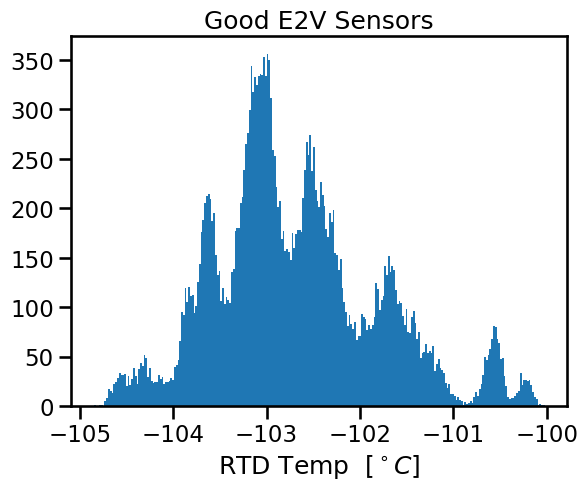

In [19]:
# select only the Temp_RXX-SYY
columns = [col for col in df.columns if 'Temp_R' in col[:10]]
good_cols = list(df[columns].columns[labels==0])

Temps = df[good_cols].to_numpy().flatten()
nbins = int(Temps.size/100)
_ = plt.hist(Temps,bins=nbins)
plt.xlabel(r'RTD Temp  [$^\circ C$]')
plt.title('Good E2V Sensors')

<AxesSubplot:xlabel='datetime'>

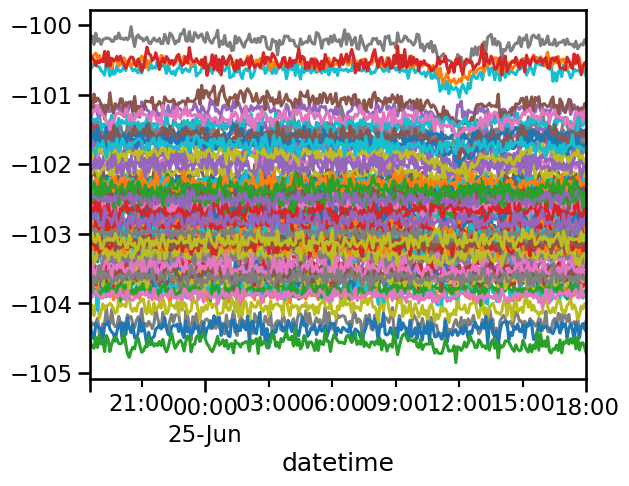

In [20]:
columns = [col for col in df.columns if 'Temp_R' in col[:10]]
good_cols = list(df[columns].columns[labels==0])
df[good_cols].plot(legend=False)

<AxesSubplot:xlabel='datetime'>

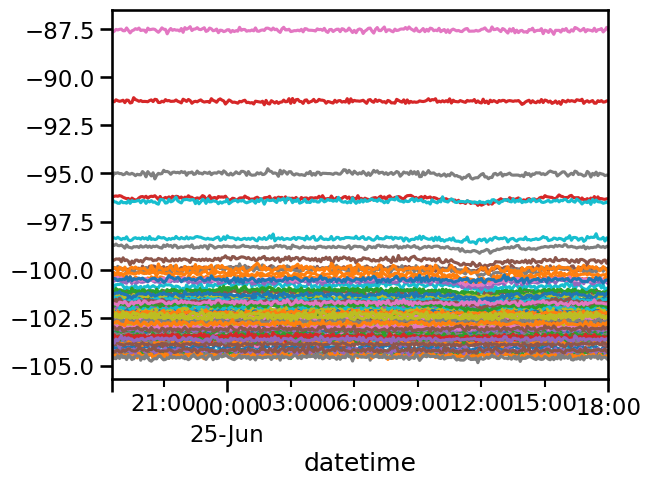

In [21]:
columns = [col for col in df.columns if 'Temp_R' in col[:10]]
good_cols = list(df[columns].columns)
df[good_cols].plot(legend=False)

## Raft Calibration

Inside a raft, the RTD Temp of a sensor should be somewhat closer to the neighbours inside the raft. To study sensors with bad reports we show the offset of the mean temperature in the raft $\Delta T_{\rm raft}$

<AxesSubplot:xlabel='datetime'>

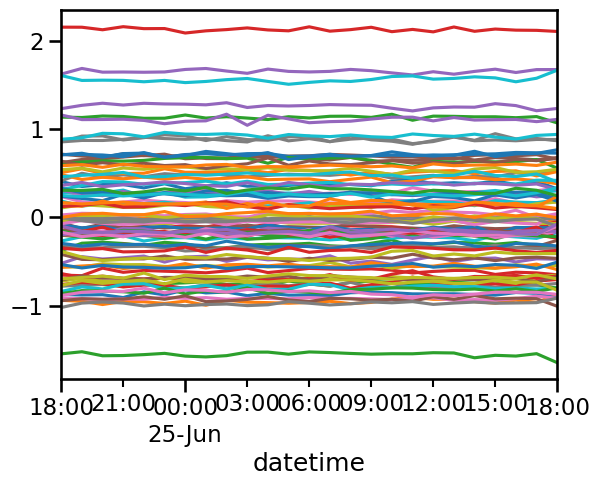

In [22]:
columns = [col for col in df.columns if 'Delta_Temp_R' in col]
bad_cols = list(df[columns].columns[labels==0])
df[bad_cols].resample('60min').mean().plot(legend=False)

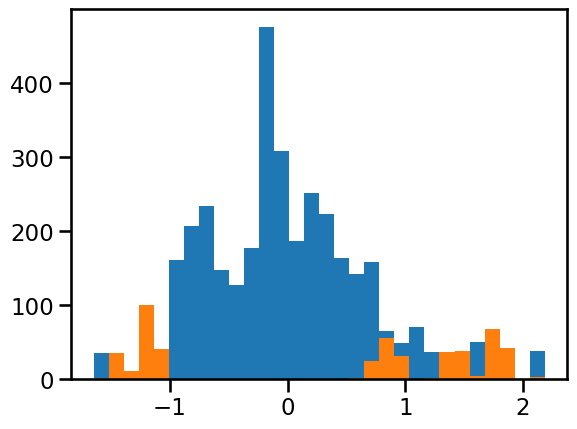

In [23]:
bad_cols = list(df[columns].columns[labels==0])
bad_cols2 = list(df[columns].columns[labels!=0])

data = df[bad_cols].resample('40min').mean().to_numpy()
data2 = df[bad_cols2].resample('40min').mean().to_numpy()
_ = plt.hist(data.flatten(),bins=30)
_ = plt.hist(data2.flatten(),bins=_[1])

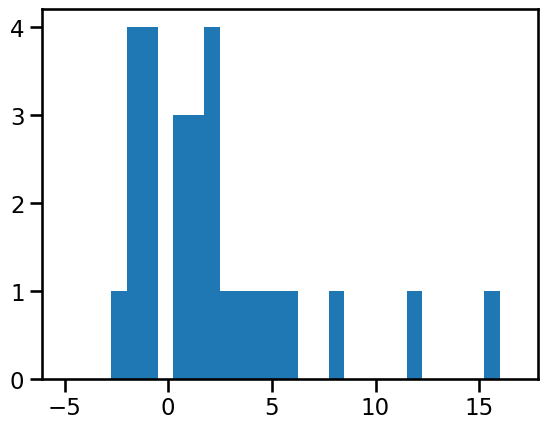

In [24]:
columns = [col for col in df.columns if 'Delta_Temp_R' in col]
bad_cols2 = list(df[columns].columns[labels!=0])
data2 = df[bad_cols2].mean().to_numpy()
# _ = plt.hist(data.flatten(),bins=30)
_ = plt.hist(data2.flatten(),bins=np.arange(-5,17,0.75))

<AxesSubplot:xlabel='datetime'>

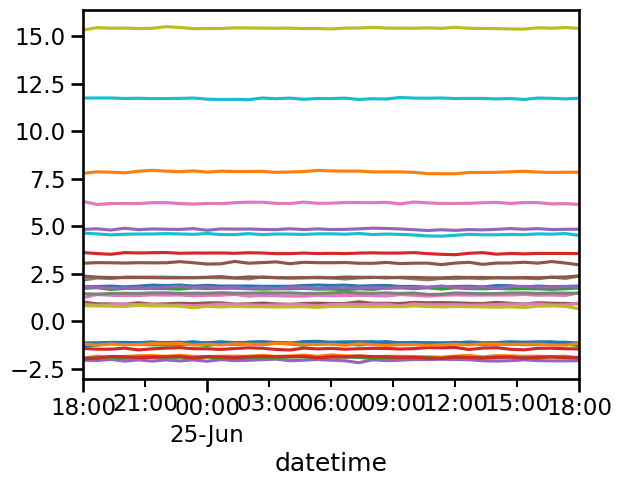

In [25]:
bad_cols = list(df[columns].columns[labels!=0])
df[bad_cols].resample('40min').mean().plot(legend=False)

## Recalibration

In [26]:
columns = [col for col in df.columns if 'Temp_R14' in col[:10]]
columns

['Temp_R14-S00',
 'Temp_R14-S01',
 'Temp_R14-S02',
 'Temp_R14-S10',
 'Temp_R14-S11',
 'Temp_R14-S12',
 'Temp_R14-S20',
 'Temp_R14-S21',
 'Temp_R14-S22']

Text(0.5, 0, 'RTD Temp  [$^\\circ C$]')

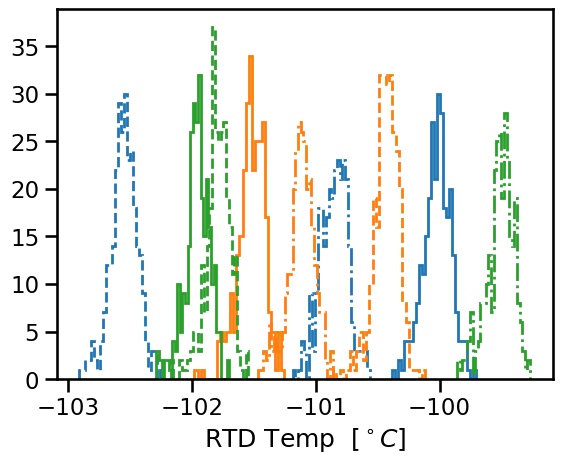

In [27]:
colors = ['tab:blue','tab:orange', 'tab:green']
lines = ['-','--','-.']
for col in columns:
    Temps = df[col].to_numpy().flatten()
    nbins = int(Temps.size/10)
    jj = int(col[-2])
    ii = int(col[-1])
    _ = plt.hist(Temps,bins=nbins, color=colors[jj], histtype='step', lw=2, ls=lines[ii])
plt.xlabel(r'RTD Temp  [$^\circ C$]')
# plt.title('Good E2V Sensors')

Text(0.5, 1.0, 'Raft 14')

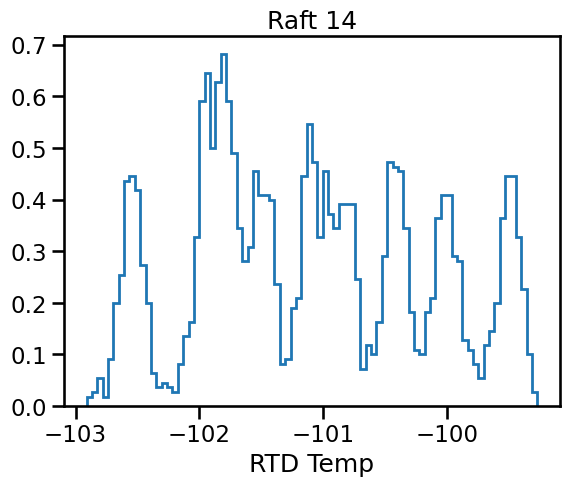

In [28]:
Temps = df[columns].to_numpy().flatten()
nbins = int(Temps.size/30)
_ = plt.hist(Temps, bins=nbins, histtype='step', lw=2, density=True)
plt.xlabel('RTD Temp')
plt.title('Raft 14')

<AxesSubplot:xlabel='datetime'>

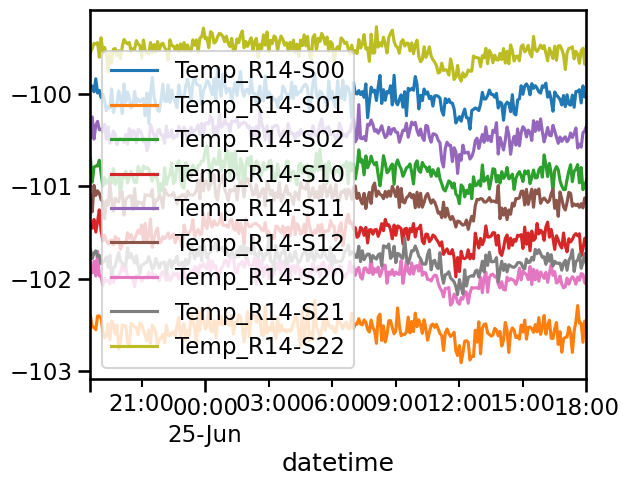

In [29]:
df[columns].plot()

The calibration over a raft is not realiable.

## Is Noise Different for Bad RTDs?

<AxesSubplot:xlabel='datetime'>

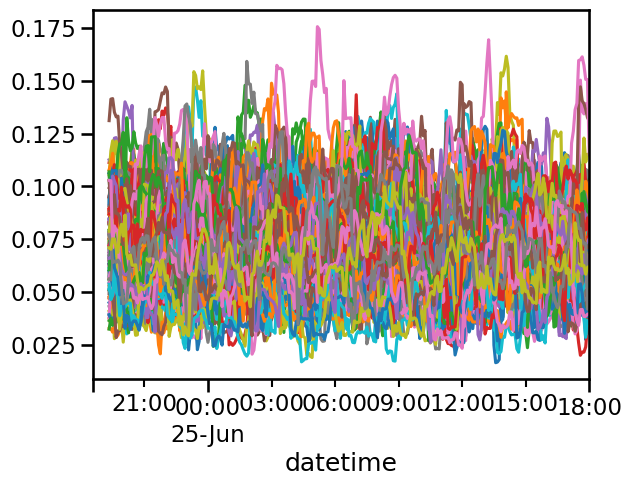

In [46]:
columns = [col for col in df.columns if 'Temp_R' in col[:10]]
good_cols = list(df[columns].columns[labels==0])
df[good_cols].rolling(window=10).std().plot(legend=False)

<AxesSubplot:xlabel='datetime'>

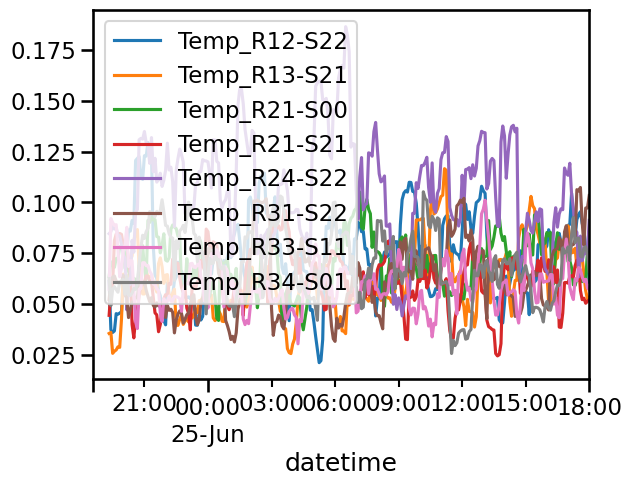

In [48]:
bad_cols = list(df[columns].columns[labels!=0])
df[bad_cols].rolling(window=10).std().plot()

## Full Focal Plane Calibration

Find groups inside the focal plane.

In [943]:
columns = [col for col in df.columns if 'Temp_R' in col[:10]]
Temps = df[columns].resample('5min').mean().to_numpy()

In [944]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# Generate sample data
# X, _ = make_blobs(n_samples=200, centers=4, random_state=42)
X = Temps.T

# Perform K-means clustering for different cluster sizes
cluster_sizes = range(2, 15)
inertias = []
silhouette_scores = []

for size in cluster_sizes:
    kmeans = KMeans(n_clusters=size, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

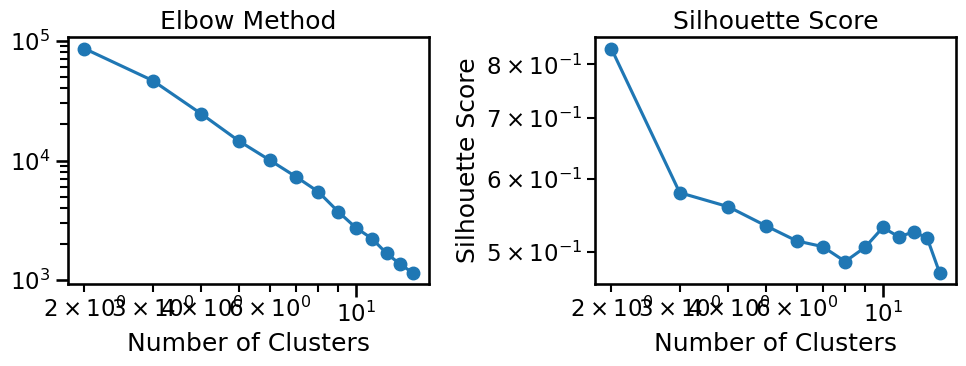

In [945]:
# Plotting the elbow curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.loglog()
plt.plot(cluster_sizes, inertias, marker='o')
plt.xlabel('Number of Clusters')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.xscale('log')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.loglog()
plt.plot(cluster_sizes, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='datetime'>

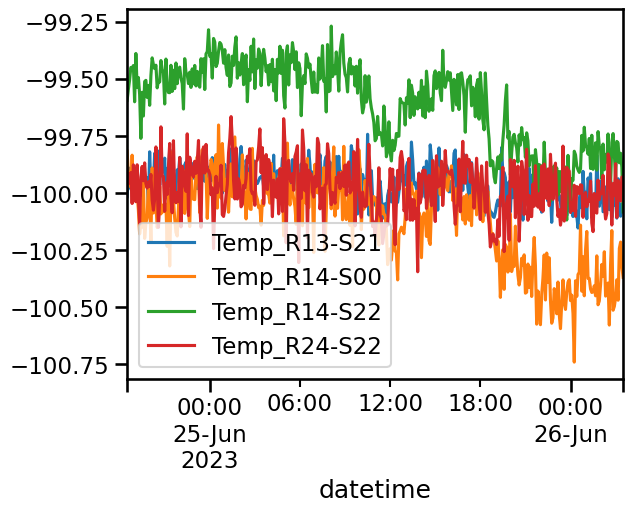

In [946]:
df[list(np.array(columns)[kmeans.labels_==8])].plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min

# Generate sample data
# X, _ = make_blobs(n_samples=200, centers=4, random_state=42)
X = Temps.flatten()[:,np.newaxis]

# Perform Gaussian Mixture Model for different numbers of components
component_range = range(3, 40)
bic_scores = []
silhouette_scores = []

for n_components in component_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    labels = gmm.predict(X)
    silhouette_scores.append(silhouette_score(X, labels))
    gmmpre = gmm

In [ ]:
# Plotting BIC scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(component_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score')

# Plotting Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(component_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


## Correlation $\Delta T $ vs $T$

We'll study the relation
$$
\Delta T_{ij} = T_{i} - T_j = A T_{i}
$$

where $i$ stands for the sensor number and $j$ for the raft number. 

## Raft 11

In [ ]:
dfmask['Tmean'] = df[columns_temp].median(axis=1)

In [ ]:
columns = [col for col in df.columns if 'Delta_Temp_R' in col]
columns_raft = [col for col in df.columns if '_mean' in col]
columns_raft = [col for col in columns_raft for i in range(9)]
columns_temp = [col for col in df.columns if 'Temp_R' in col[:10]]

# Tmean = df[['Tmean' for i in range(len(columns_temp))]].resample('10min').mean().to_numpy().T

temp = df[columns_temp].resample('30s').mean().to_numpy().T
tempRaft = df[columns_raft].resample('30s').mean().to_numpy().T
dtemp = temp-tempRaft

In [ ]:
Tmean.mean()

In [ ]:
# pars, pcov = curve_fit(linear, temp.flatten()-Tmean.mean(), dtemp.flatten())
# pars

In [ ]:
i = 6
plt.scatter(tempRaft[i], temp[i]-tempRaft[i])

i = 3
plt.scatter(tempRaft[i], temp[i]-tempRaft[i])

In [ ]:
from scipy.optimize import curve_fit
linear = lambda T, a, b: a*T + b
nsize = dtemp.shape[0]
output = np.zeros((nsize,2))
for i in range(nsize):
    isnan = np.isnan(temp[i])
    pars, pcov = curve_fit(linear, temp[i][~isnan], (temp[i]-tempRaft[i])[~isnan])
    output[i] = pars

In [ ]:
_ = plt.hist(output[:,0],bins=40)

In [ ]:
plt.scatter(output[:,0], mymean)

In [919]:
columns_temp

['Temp_R11-S00',
 'Temp_R11-S01',
 'Temp_R11-S02',
 'Temp_R11-S10',
 'Temp_R11-S11',
 'Temp_R11-S12',
 'Temp_R11-S20',
 'Temp_R11-S21',
 'Temp_R11-S22',
 'Temp_R12-S00',
 'Temp_R12-S01',
 'Temp_R12-S02',
 'Temp_R12-S10',
 'Temp_R12-S11',
 'Temp_R12-S12',
 'Temp_R12-S20',
 'Temp_R12-S21',
 'Temp_R12-S22',
 'Temp_R13-S00',
 'Temp_R13-S01',
 'Temp_R13-S02',
 'Temp_R13-S10',
 'Temp_R13-S11',
 'Temp_R13-S12',
 'Temp_R13-S20',
 'Temp_R13-S21',
 'Temp_R13-S22',
 'Temp_R14-S00',
 'Temp_R14-S01',
 'Temp_R14-S02',
 'Temp_R14-S10',
 'Temp_R14-S11',
 'Temp_R14-S12',
 'Temp_R14-S20',
 'Temp_R14-S21',
 'Temp_R14-S22',
 'Temp_R21-S00',
 'Temp_R21-S01',
 'Temp_R21-S02',
 'Temp_R21-S10',
 'Temp_R21-S11',
 'Temp_R21-S12',
 'Temp_R21-S20',
 'Temp_R21-S21',
 'Temp_R21-S22',
 'Temp_R22-S00',
 'Temp_R22-S01',
 'Temp_R22-S02',
 'Temp_R22-S10',
 'Temp_R22-S11',
 'Temp_R22-S12',
 'Temp_R22-S20',
 'Temp_R22-S21',
 'Temp_R22-S22',
 'Temp_R23-S00',
 'Temp_R23-S01',
 'Temp_R23-S02',
 'Temp_R23-S10',
 'Temp_R23-S11

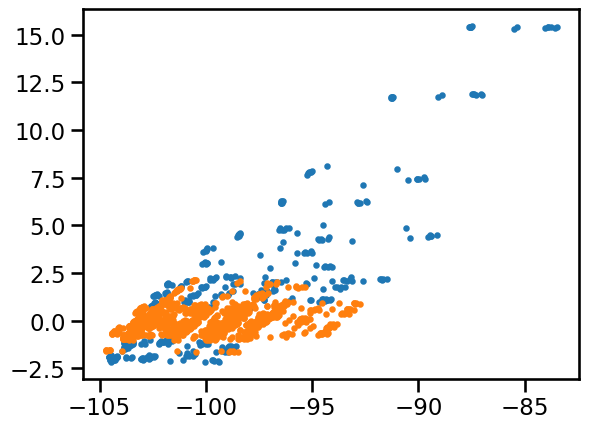

In [892]:
columns = [col for col in df.columns if 'Delta_Temp_R' in col]
columns_temp = [col for col in df.columns if 'Temp_R' in col[:10]]

for i in range(2):
    bad_cols = list(df[columns].columns[labels!=i])
    bad_cols_temp = list(df[columns_temp].columns[labels!=i])

    deltaTs = df[bad_cols].resample('20min').mean().to_numpy().T
    Ts = df[bad_cols_temp].resample('20min').mean().to_numpy().T

    plt.scatter(Ts.flatten(), deltaTs.flatten(), s=10)